In [707]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import cv2
import random

In [708]:
import pandas as pd

X = pd.read_csv('Vector_Quantile_Regression/Data/MVEngelX.csv', header= None)
Y = pd.read_csv('Vector_Quantile_Regression/Data/MVEngelY.csv', header= None)

X.columns = ['X']
Y.columns = ['Y1', 'Y2']

df = Y
df['Intercept'] =1
df['X'] = X
#df['X2'] = X**2

df.head(5)

,Y1,Y2,Intercept,X
0,576.28,125.12,1,835.94
1,631.80,153.64,1,873.44
2,608.64,186.00,1,951.44
3,301.00,122.00,1,473.00
4,378.00,134.00,1,601.00


In [711]:
X = df[['Intercept', 'X']].to_numpy()
Y = df[['Y1', 'Y2']].to_numpy()


step = 0.05

x = np.arange(0, 1+step, step)
y = np.arange(0, 1+step, step)
x,y = np.meshgrid(x,y)

u=np.array([x.flatten(),y.flatten()]).T

In [712]:
U = u.T
Y = Y.T

In [713]:
U.shape , Y.shape

((2, 441), (2, 235))

In [714]:
n = Y.shape[1]
m = U.shape[1]


In [715]:
normalize = lambda a: a/np.sum(a)
nu = normalize(np.random.rand(n, 1))
mu = normalize(np.random.rand(m, 1))

In [716]:
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)
C = distmat(U,Y)

In [717]:
P = cp.Variable((m,n))
ind_n = np.ones((n,1))
ind_m = np.ones((m,1))

In [718]:
constraints = [0 <= P, cp.matmul(P.T,ind_m)==nu, cp.matmul(P,X)==cp.matmul(cp.matmul(mu,nu.T),X)]

In [719]:
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
prob = cp.Problem(objective, constraints)
result = prob.solve()

In [720]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(P.value[P.value>1e-5]), n + m-1))

Number of non-zero: 5036 (n + m-1 = 675)


In [721]:
psi = constraints[1].dual_value
b = constraints[2].dual_value

# Precious function

In [722]:
def get_dfU(U, b,step):
    d = U.T.shape[1]
    dfU = pd.DataFrame(u)
    dim = [i for i in range(d)]
    dfU[[str(i)+"_follower" for i in list(dfU.columns)]] = dfU[dfU.columns]

    for k in range(d):
    
        dfU_temp = dfU.copy()
        dfU_temp[k] = dfU_temp[k].apply(lambda x: x+step if x<1 else x-step )
    
        find_in = list(dfU[dim].apply(lambda x: list(np.around(x, 3)),axis=1))
    
        dfU[str(k)+"_follower"] = dfU_temp[dim].apply(lambda x: list(np.around(x, 3)), axis =1).apply(lambda x: find_in.index(x))
    
    dfU['b']=pd.DataFrame(b).apply(np.array,axis=1)
    
    for i in range(d):
        dfU['beta_'+str(i)]=(dfU.loc[list(dfU[str(i)+"_follower"])][['b']].reset_index(drop=True) - dfU[['b']])/step
    
    beta = ['beta_'+str(i) for i in range(2)]
    dfU['beta'] = dfU[beta].apply(lambda x : np.vstack(x), axis = 1)
    
    return dfU

In [759]:
xeval = np.array([1,883.99])
xeval.shape

(2,)

In [760]:
df = get_dfU(U, b,step)

In [761]:
y_hat = df['beta'].apply(lambda x : np.matmul(x, xeval))

In [762]:
y_1_hat = y_hat.apply(lambda x: x[0])
y_2_hat = y_hat.apply(lambda x: x[1])

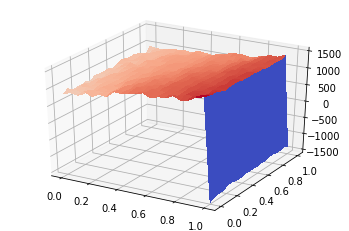

In [768]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

x = np.reshape(df[0].ravel(), (21, 21))
y = np.reshape(df[1].ravel(), (21, 21))
z = np.reshape(y_1_hat.ravel(), (21, 21))

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


plt.show()

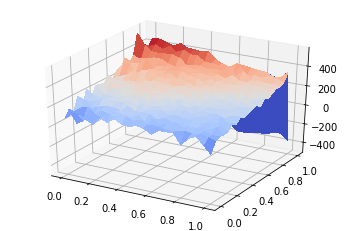

In [764]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

x = np.reshape(df[0].ravel(), (21, 21))
y = np.reshape(df[1].ravel(), (21, 21))
z = np.reshape(y_2_hat.ravel(), (21, 21))

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


plt.show()

# Backup

In [679]:
def grad2D(f,T,U,step):
    EPS = 0.0001
    fact = 10/step
    l = len(T)
    m = U.shape[0]
    D1 = np.ones((m,1))*0
    D2 = np.ones((m,1))*0
    
    which = lambda lst:list(np.where(lst)[0])
    
    liste = [i+1 for i in range(l)]
    for i1 in liste :
        u1=T[i1]
        for i2 in liste : 
            u2=T[i2]
            j=which((fact*U[:,1] + U[:,2])==(fact*u1+u2))
            jprecx = which(abs((fact*U[:,1] + U[:,2])-(fact*(u1-step)+u2))<EPS)
            jprecy = which(abs((fact*U[:,1] + U[:,2])-(fact*u1+(u2-step)))<EPS)
            #if ((len(jprecx)!=1)|(len(jprecy)!=1)):
            #    print("Problem in grad2D")
            #    return None
            D1[j]=(f[j]-f[jprecx])/step
            D2[j]=(f[j]-f[jprecy])/step
    
    return (D1,D2)

def ComputeBetaEtAl2D(b_prov,T,U_prov,pi_prov,step):
    m_prov = b_prov.shape[0]
    r = b_prov.shape[1]
    n = pi_prov.shape[1]
    
    which = lambda lst:list(np.where(lst)[0])
    nonzind= which((U_prov[:,1] != 0) & (U_prov[:,2] != 0))
    U = np.c_[U_prov[nonzind,0],U_prov[nonzind,1]]
    m = U.shape[0]
    mu = np.ones((m,1))/m
    beta1 = np.ones((m,r))*0 
    beta2 = np.ones((m,r))*0 
    for k in range(r):
        theGrad = grad2D(b_prov[:,k],T,U_prov,step)
        beta1[:,0], beta2[:,k] = grad2D(b_prov[:,k],T,U_prov,step)
    pi=np.ones((m,n))*0
    for i in range(n):
        pi[:,i]=pi_prov[nonzind,i] 
        
    b = b_prov[nonzind]
    return (beta1,beta2,U,m,mu,pi,b)